<img style="float: right;" src="files/resources/general/thehyve_logo.png">
# TranSMART 17.1 REST API demonstration
---------------
Copyright (c) 2017 The Hyve B.V. This notebook is licensed under the GNU General Public License, version 3. Authors: 
 - Ward Weistra
 - Jochem Bijlard


We start by importing the tranSMART Python library (https://pypi.python.org/pypi/transmart) and connecting to the tranSMART server.

Prerequisites:
- Install `pandas`, `transmart` and `matplotlib` with `pip install <packagename>`

In [1]:
import transmart as tm
print('transmart python client version: {}'.format(tm.__version__))

transmart python client version: 0.2.4


In [2]:
# Let's login with our username and password.
# If you don't have an account yet, register at https://glowingbear.thehyve.net
import getpass

api = tm.get_api(
    host = 'https://transmart.thehyve.net',
    user = input('Username:'),
    password = getpass.getpass('Password:'),
    api_version = 2,
    kc_url = 'https://keycloak-dwh-test.thehyve.net',
    kc_realm = 'transmart',
    print_urls = True)

Username:ward-demo
Password:········
https://transmart.thehyve.net/v2/studies
https://transmart.thehyve.net/v2/tree_nodes?depth=0&counts=False&tags=True
Existing index cache found. Loaded 2404 tree nodes. Hooray!
https://transmart.thehyve.net/v2/pedigree/relation_types


Next we import and configure Pandas, a Python library that helps us to work with the data. One of main concepts it has borrowed from `R`, you can do most of your data manipulation using dataframes.

For future versions we would like to incorporate this and integration with Jupyter itself more closely into the Python client, but for now we will do some of the dirty work manually.

In [3]:
import pandas as pd
from pandas.io.json import json_normalize

pd.set_option('max_colwidth', 1000)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

## Whats is in the box?

As a first REST API call it would be nice to see what studies are available in this tranSMART server.
  
You will see a list of all studies, their name (i.e. `studyId`) and what dimensions are available for this study. Remember that tranSMART previously only supported the dimensions patients, concepts and studies. Now you should see studies with many more dimensions! 

**NOTE: The API shows you what handles it is connecting to!**

In [4]:
studies = api.get_studies()
studies.dataframe.head()

https://transmart.thehyve.net/v2/studies


,bioExperimentId,dimensions,id,secureObjectToken,studyId
0,-10.0,"[study, concept, patient]",-20,PUBLIC,CATEGORICAL_VALUES
1,-11.0,"[study, concept, patient, trial visit]",-21,PUBLIC,CLINICAL_TRIAL
2,-20.0,"[assay, projection, study, concept, patient, trial visit, biomarker]",-30,PUBLIC,CLINICAL_TRIAL_HIGHDIM
3,-12.0,"[study, concept, patient, visit, end time, start time]",-22,PUBLIC,EHR
4,-21.0,"[assay, projection, study, concept, patient, visit, end time, start time, biomarker]",-31,PUBLIC,EHR_HIGHDIM


## Part 1: Plotting blood pressure over time
To answer a real question that uses the REST api and the new time dimension we will create plots of a sample dataset with blood pressure measured at multiple time points. To explore what we have in this project we will:
 
 1. have a look at the patients
 1. have a look at observations
 1. create a subset of data we want to plot
 1. create aggregated plots


For this tutorial we will be using a preloaded project with the studyID `TRAINING`.

In [5]:
STUDY_ID = 'TRAINING'
c = api.new_constraint(study=STUDY_ID)
c

ObservationConstraint(study='TRAINING')

### 1.0 What is the structure of this study?
To get an overview of the transmart study, the shape of the tree is a good first step.

In [6]:
tree = api.tree_nodes(root='\\Public Studies\\Training\\', counts=True)

https://transmart.thehyve.net/v2/tree_nodes?depth=0&counts=True&tags=True&root=\Public Studies\Training\


In [7]:
tree

Training  (12)/
  Demographics  (None)/
    Age  (12)
    Gender  (None)/
      Female  (6)
      Male  (6)
  Measurements  (None)/
    Blood pressure  (12)
    Method  (None)/
      Palpatory Systolic Pressure  (12)
  Study Design  (None)/
    Group  (None)/
      Control  (6)
      Treatment  (6)

### 1.1 Getting the patients for this study
We choose the TRAINING study and ask for all patients in this study using the `patients()` function. You will get a list with their patient details and patient identifiers. The variables you see (e.g. `Age`, `Sex`, and `Race`) historically have a special place in tranSMART and are often stored as both and observation and in this patient relationship table.

In [8]:
patients = api.patients(constraint=c)
patients.dataframe

https://transmart.thehyve.net/v2/patients


,age,birthDate,deathDate,id,inTrialId,maritalStatus,race,religion,sex,trial
0,43,None,None,1000384804,subject_3,None,None,None,FEMALE,TRAINING
1,66,None,None,1000384800,subject_7,None,None,None,MALE,TRAINING
2,48,None,None,1000384798,subject_9,None,None,None,MALE,TRAINING
3,43,None,None,1000384806,subject_1,None,None,None,MALE,TRAINING
4,42,None,None,1000384816,subject_11,None,None,None,FEMALE,TRAINING
5,66,None,None,1000384815,subject_12,None,None,None,FEMALE,TRAINING
6,52,None,None,1000384801,subject_6,None,None,None,FEMALE,TRAINING
7,38,None,None,1000384802,subject_5,None,None,None,MALE,TRAINING
8,41,None,None,1000384805,subject_2,None,None,None,FEMALE,TRAINING
9,41,None,None,1000384797,subject_10,None,None,None,FEMALE,TRAINING


### 1.2 Getting the observations

Next we ask for the full list of observations for this study. This list will include one row per observation, with information from all their dimensions. The columns will have headers like `<dimension name>.<field name>` and `numericValue` or `stringValue` for the actual observation value.

In [9]:
observations = api.observations(constraint=c)
observations.dataframe.head()

https://transmart.thehyve.net/v2/observations?constraint={"studyId": "TRAINING", "type": "study_name"}&type=clinical


,concept.conceptCode,concept.conceptPath,concept.name,end time,location,numericValue,patient.age,patient.birthDate,patient.deathDate,patient.id,patient.inTrialId,patient.maritalStatus,patient.race,patient.religion,patient.sex,patient.sexCd,patient.trial,start time,stringValue,study.name,trial visit.id,trial visit.relTime,trial visit.relTimeLabel,trial visit.relTimeUnit
0,1341223,\Public Studies\Training\Demographics\Gender\Male\,Male,None,@,NaN,43,None,None,1000384806,subject_1,None,None,None,male,Male,TRAINING,None,Male,TRAINING,50,NaN,Default,None
1,1341222,\Public Studies\Training\Demographics\Age\,Age,None,@,43.1,43,None,None,1000384806,subject_1,None,None,None,male,Male,TRAINING,None,NaN,TRAINING,50,NaN,Default,None
2,1341216,\Public Studies\Training\Study Design\Group\Control\,Control,None,@,NaN,43,None,None,1000384806,subject_1,None,None,None,male,Male,TRAINING,None,Control,TRAINING,50,NaN,Default,None
3,1341217,\Public Studies\Training\Measurements\Method\Palpatory Systolic Pressure\,Palpatory Systolic Pressure,None,@,NaN,43,None,None,1000384806,subject_1,None,None,None,male,Male,TRAINING,None,Palpatory Systolic Pressure,TRAINING,50,NaN,Default,None
4,1341221,\Public Studies\Training\Demographics\Gender\Female\,Female,None,@,NaN,41,None,None,1000384805,subject_2,None,None,None,female,Female,TRAINING,None,Female,TRAINING,50,NaN,Default,None


In [10]:
# A quick overview of the columns in the returned dataframe.
print('The columns in our dataframe are:')
for index, column in enumerate(observations.dataframe.columns):
    print(' {:>5} {}'.format(index, column))

The columns in our dataframe are:
     0 concept.conceptCode
     1 concept.conceptPath
     2 concept.name
     3 end time
     4 location
     5 numericValue
     6 patient.age
     7 patient.birthDate
     8 patient.deathDate
     9 patient.id
    10 patient.inTrialId
    11 patient.maritalStatus
    12 patient.race
    13 patient.religion
    14 patient.sex
    15 patient.sexCd
    16 patient.trial
    17 start time
    18 stringValue
    19 study.name
    20 trial visit.id
    21 trial visit.relTime
    22 trial visit.relTimeLabel
    23 trial visit.relTimeUnit


In [11]:
# And a list with the available concepts in this dataset:
available_concepts = observations.dataframe.loc[:, 'concept.conceptPath'].unique()

print('Available concepts for this study:')
for index, concept in enumerate(sorted(available_concepts)):
    print('{:>5} {}'.format(index, concept))

Available concepts for this study:
    0 \Public Studies\Training\Demographics\Age\
    1 \Public Studies\Training\Demographics\Gender\Female\
    2 \Public Studies\Training\Demographics\Gender\Male\
    3 \Public Studies\Training\Measurements\Blood pressure\
    4 \Public Studies\Training\Measurements\Method\Palpatory Systolic Pressure\
    5 \Public Studies\Training\Study Design\Group\Control\
    6 \Public Studies\Training\Study Design\Group\Treatment\


### 1.3 Subsetting on the data we want

For this exercise we are primarily interested in subject blood pressure. So lets select only data from our set that we want to use.

In [12]:
concept_groups = observations.dataframe.groupby('concept.conceptPath')
blood_pressure_observations = concept_groups.get_group('\\Public Studies\\Training\\Measurements\\Blood pressure\\')
blood_pressure_observations

,concept.conceptCode,concept.conceptPath,concept.name,end time,location,numericValue,patient.age,patient.birthDate,patient.deathDate,patient.id,patient.inTrialId,patient.maritalStatus,patient.race,patient.religion,patient.sex,patient.sexCd,patient.trial,start time,stringValue,study.name,trial visit.id,trial visit.relTime,trial visit.relTimeLabel,trial visit.relTimeUnit
48,1341214,\Public Studies\Training\Measurements\Blood pressure\,Blood_pressure,None,@,78.32885,43,None,None,1000384806,subject_1,None,None,None,male,Male,TRAINING,None,NaN,TRAINING,68,21.0,Week 3,days
49,1341214,\Public Studies\Training\Measurements\Blood pressure\,Blood_pressure,None,@,84.69299,43,None,None,1000384806,subject_1,None,None,None,male,Male,TRAINING,None,NaN,TRAINING,68,21.0,Week 3,days
50,1341214,\Public Studies\Training\Measurements\Blood pressure\,Blood_pressure,None,@,73.96482,41,None,None,1000384805,subject_2,None,None,None,female,Female,TRAINING,None,NaN,TRAINING,68,21.0,Week 3,days
51,1341214,\Public Studies\Training\Measurements\Blood pressure\,Blood_pressure,None,@,90.02295,41,None,None,1000384805,subject_2,None,None,None,female,Female,TRAINING,None,NaN,TRAINING,68,21.0,Week 3,days
52,1341214,\Public Studies\Training\Measurements\Blood pressure\,Blood_pressure,None,@,89.05304,43,None,None,1000384804,subject_3,None,None,None,female,Female,TRAINING,None,NaN,TRAINING,68,21.0,Week 3,days
53,1341214,\Public Studies\Training\Measurements\Blood pressure\,Blood_pressure,None,@,92.15853,43,None,None,1000384804,subject_3,None,None,None,female,Female,TRAINING,None,NaN,TRAINING,68,21.0,Week 3,days
54,1341214,\Public Studies\Training\Measurements\Blood pressure\,Blood_pressure,None,@,81.28030,49,None,None,1000384803,subject_4,None,None,None,male,Male,TRAINING,None,NaN,TRAINING,68,21.0,Week 3,days
55,1341214,\Public Studies\Training\Measurements\Blood pressure\,Blood_pressure,None,@,87.00935,49,None,None,1000384803,subject_4,None,None,None,male,Male,TRAINING,None,NaN,TRAINING,68,21.0,Week 3,days
56,1341214,\Public Studies\Training\Measurements\Blood pressure\,Blood_pressure,None,@,81.84076,38,None,None,1000384802,subject_5,None,None,None,male,Male,TRAINING,None,NaN,TRAINING,68,21.0,Week 3,days
57,1341214,\Public Studies\Training\Measurements\Blood pressure\,Blood_pressure,None,@,86.09609,38,None,None,1000384802,subject_5,None,None,None,male,Male,TRAINING,None,NaN,TRAINING,68,21.0,Week 3,days


In [13]:
# Get the columns I want to use and give them better names.
columns_of_interest = ['patient.inTrialId', 'trial visit.relTimeLabel', 'numericValue']
blood_pressure_subset = blood_pressure_observations.loc[:, columns_of_interest]
blood_pressure_subset.columns = ['subject', 'visit_label', 'blood_pressure']
blood_pressure_subset.head()

,subject,visit_label,blood_pressure
48,subject_1,Week 3,78.32885
49,subject_1,Week 3,84.69299
50,subject_2,Week 3,73.96482
51,subject_2,Week 3,90.02295
52,subject_3,Week 3,89.05304


### 1.4 So lets create some plots!!

First import our plotting library and tell Jupyter to directly show the images we create using `matplotlib`.

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

TranSMARTs new data model allows for an arbirary number of observations per concept and/or trial visit. As you perhaps noticed in the previous step, in our example blood measure been measured twice per patient for each visit. In the plot we want to create we want to use the mean of these two values.

In [15]:
bp_pivot = blood_pressure_subset.pivot_table(index='visit_label', 
                                             values='blood_pressure', 
                                             columns='subject', 
                                             aggfunc='mean')
bp_pivot

subject,subject_1,subject_10,subject_11,subject_12,subject_2,subject_3,subject_4,subject_5,subject_6,subject_7,subject_8,subject_9
visit_label,,,,,,,,,,,,
Week 1,79.791680,76.297885,75.76817,73.382130,87.080345,80.859350,83.156315,73.173735,78.307655,78.827605,75.943940,80.312125
Week 2,74.032555,69.147425,69.94658,76.121270,84.682915,81.651790,72.205680,82.087085,82.386450,75.005220,72.003335,73.109515
Week 3,81.510920,59.065585,56.15305,56.800885,81.993885,90.605785,84.144825,83.968425,81.269235,65.536295,58.798970,63.988280


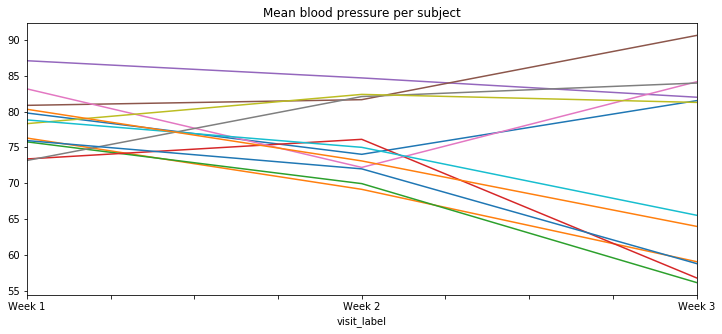

In [16]:
subject_plot = bp_pivot.plot(legend=False, 
                             figsize=(12, 5),
                             title='Mean blood pressure per subject')

### 1.4b Masking with treatment

Included in our example project is a treatment which we suspect lowers blood pressure. Let's include that in our analysis by adding it to our dataframe and creating a pivot based on that.

In [17]:
control_concept = '\\Public Studies\\Training\\Study Design\\Group\\Control\\'
treated_concept = '\\Public Studies\\Training\\Study Design\\Group\\Treatment\\'

control_group = list(concept_groups.get_group(control_concept).loc[:, 'patient.inTrialId'])
treated_group = list(concept_groups.get_group(treated_concept).loc[:, 'patient.inTrialId'])

In [18]:
def control_or_treated(observation):
    if observation.subject in control_group:
        return 'Control'
    if observation.subject in treated_group:
        return 'Treated'

blood_pressure_subset['treatment_group'] = blood_pressure_subset.apply(control_or_treated, axis=1)

In [19]:
treatment_pivot = blood_pressure_subset.pivot_table(index='visit_label', 
                                                    values='blood_pressure', 
                                                    columns='treatment_group', 
                                                    aggfunc='mean')

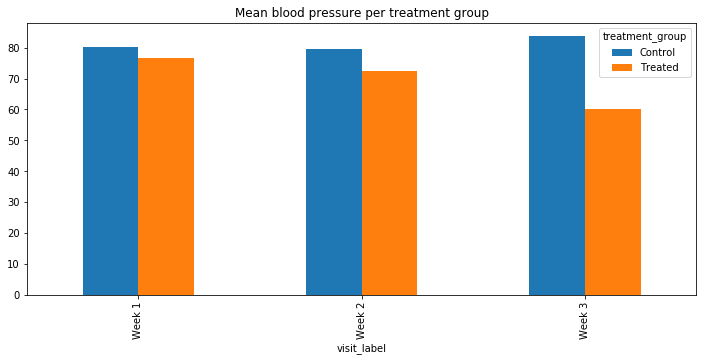

In [20]:
treatment_plot = treatment_pivot.plot(kind='bar',
                                      figsize=(12, 5),
                                      title='Mean blood pressure per treatment group')

## Part 2: Combining Glowing Bear and the Python client

For the second part we will work with the Glowing Bear user interface that was developed at The Hyve, funded by IMI Translocation and BBMRI.

An API is great to extract exactly the data you need and analyze that. But it is harder to get a nice overview of all data that is available and define the exact set to extract. That is where the Glowing Bear was built for.

Please go to http://glowingbear.thehyve.net and create a Patient Set on the Data Selection tab (under Select patients). Once you have saved your patient set, copy the patient set identifier and paste that below.

In [21]:
patient_sets = api.patient_sets()

https://transmart.thehyve.net/v2/patient_sets


In [22]:
patient_sets.dataframe.head()

,apiVersion,description,errorMessage,id,queryXML,requestConstraints,setSize,status,username
0,v2,Cross table set,None,29251,None,"{""type"":""and"",""args"":[{""type"":""subselection"",""dimension"":""patient"",""constraint"":{""type"":""and"",""args"":[{""type"":""concept"",""conceptCode"":""O1KP:GENDER""},{""type"":""study_name"",""studyId"":""ORACLE_1000_PATIENT""},{""type"":""value"",""valueType"":""STRING"",""operator"":""="",""value"":""Male""}]}},{""type"":""subselection"",""dimension"":""patient"",""constraint"":{""type"":""and"",""args"":[{""type"":""concept"",""conceptCode"":""O1KP:CAT1""},{""type"":""study_name"",""studyId"":""ORACLE_1000_PATIENT""},{""type"":""value"",""valueType"":""STRING"",""operator"":""="",""value"":""Leg""}]}}]}",74,FINISHED,74814585-2219-4fd4-8766-11adbb2adbae
1,v2,Cross table set,None,29230,None,"{""type"":""true""}",1834,FINISHED,74814585-2219-4fd4-8766-11adbb2adbae
2,v2,Cross table set,None,29231,None,"{""type"":""and"",""args"":[{""type"":""concept"",""conceptCode"":""O1KP:GENDER""},{""type"":""study_name"",""studyId"":""ORACLE_1000_PATIENT""},{""type"":""value"",""valueType"":""STRING"",""operator"":""="",""value"":""Male""}]}",618,FINISHED,74814585-2219-4fd4-8766-11adbb2adbae
3,v2,Cross table set,None,29232,None,"{""type"":""and"",""args"":[{""type"":""concept"",""conceptCode"":""O1KP:GENDER""},{""type"":""study_name"",""studyId"":""ORACLE_1000_PATIENT""},{""type"":""value"",""valueType"":""STRING"",""operator"":""="",""value"":""Female""}]}",582,FINISHED,74814585-2219-4fd4-8766-11adbb2adbae
4,v2,Cross table set,None,29233,None,"{""type"":""study_name"",""studyId"":""ORACLE_1000_PATIENT""}",1200,FINISHED,74814585-2219-4fd4-8766-11adbb2adbae


In [23]:
# Select a patient set from the above list. If there's none yet, first save a patient set in Glowing Bear
patient_set_id = 29251

Now let's return all patients for the patient set we made!

In [24]:
c = api.new_constraint(subject_set_id=patient_set_id)
patients = api.patients(constraint=c)
patients.dataframe.head()

https://transmart.thehyve.net/v2/patients


,age,birthDate,deathDate,id,inTrialId,maritalStatus,race,religion,sex,subjectIds.SUBJ_ID,trial
0,50,None,None,1000383590,subject_11,None,None,None,MALE,O1KP:1011,ORACLE_1000_PATIENT
1,50,None,None,1000383561,subject_40,None,None,None,MALE,O1KP:1040,ORACLE_1000_PATIENT
2,50,None,None,1000383550,subject_51,None,None,None,MALE,O1KP:1051,ORACLE_1000_PATIENT
3,50,None,None,1000383528,subject_73,None,None,None,MALE,O1KP:1073,ORACLE_1000_PATIENT
4,50,None,None,1000383497,subject_104,None,None,None,MALE,O1KP:1104,ORACLE_1000_PATIENT


And do the same for all observations for this patient set.

In [25]:
observations = api.observations(constraint=c, as_dataframe=True)
observations.head()

https://transmart.thehyve.net/v2/observations?constraint={"type": "patient_set", "patientSetId": 29251}&type=clinical


,concept.conceptCode,concept.conceptPath,concept.name,end time,location,numericValue,patient.age,patient.birthDate,patient.deathDate,patient.id,patient.inTrialId,patient.maritalStatus,patient.race,patient.religion,patient.sex,patient.sexCd,patient.subjectIds.SUBJ_ID,patient.trial,start time,stringValue,study.name,trial visit.id,trial visit.relTime,trial visit.relTimeLabel,trial visit.relTimeUnit
0,O1KP:AGE,\Public Studies\Oracle_1000_Patient\Demographics\Age\,Age,None,@,65.0,65,None,None,1000382409,subject_1192,None,None,None,male,Male,O1KP:2192,ORACLE_1000_PATIENT,None,NaN,ORACLE_1000_PATIENT,-101,None,General,None
1,O1KP:AGE,\Public Studies\Oracle_1000_Patient\Demographics\Age\,Age,None,@,65.0,65,None,None,1000382434,subject_1167,None,None,None,male,Male,O1KP:2167,ORACLE_1000_PATIENT,None,NaN,ORACLE_1000_PATIENT,-101,None,General,None
2,O1KP:AGE,\Public Studies\Oracle_1000_Patient\Demographics\Age\,Age,None,@,65.0,65,None,None,1000382487,subject_1114,None,None,None,male,Male,O1KP:2114,ORACLE_1000_PATIENT,None,NaN,ORACLE_1000_PATIENT,-101,None,General,None
3,O1KP:AGE,\Public Studies\Oracle_1000_Patient\Demographics\Age\,Age,None,@,65.0,65,None,None,1000382494,subject_1107,None,None,None,male,Male,O1KP:2107,ORACLE_1000_PATIENT,None,NaN,ORACLE_1000_PATIENT,-101,None,General,None
4,O1KP:AGE,\Public Studies\Oracle_1000_Patient\Demographics\Age\,Age,None,@,65.0,65,None,None,1000382495,subject_1106,None,None,None,male,Male,O1KP:2106,ORACLE_1000_PATIENT,None,NaN,ORACLE_1000_PATIENT,-101,None,General,None


Now you know exactly how to retrieve data from a tranSMART 2017 server and analyze this with Python! Please feel free to change this code in anyway you like. And if you have any questions, reach us at our public forum via development@thehyve.nl or https://groups.google.com/a/thehyve.nl/forum/#!forum/development.